In [5]:
from diffusers import StableDiffusionPipeline
import torch

model_id = "runwayml/stable-diffusion-v1-5"
pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16)
pipe = pipe.to("cuda")

prompt = "a photo of monkey riding a horse on mars"
image = pipe(prompt).images[0]  

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


  0%|          | 0/50 [00:00<?, ?it/s]

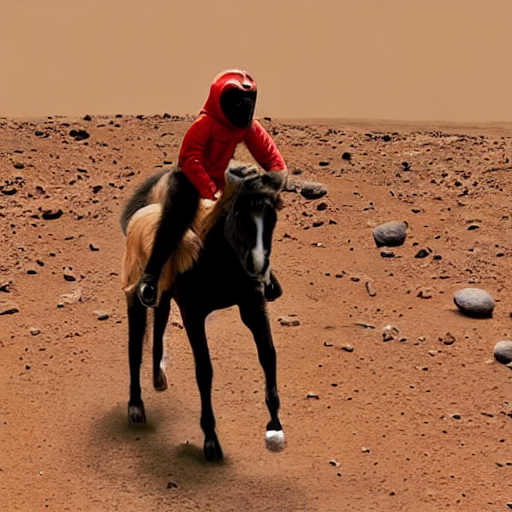

In [6]:
image

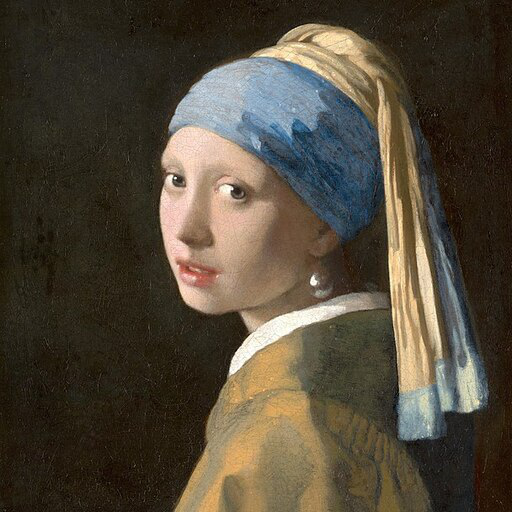

In [5]:
from diffusers import StableDiffusionControlNetPipeline
from diffusers.utils import load_image

image = load_image("https://hf.co/datasets/huggingface/documentation-images/resolve/main/diffusers/input_image_vermeer.png")

image

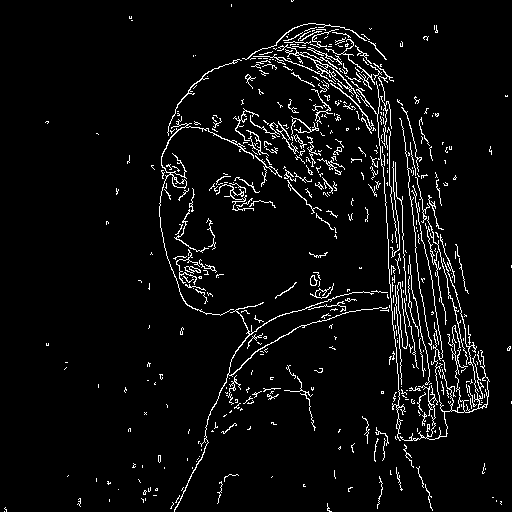

In [6]:
import cv2
from PIL import Image
import numpy as np

low_threshold = 100
high_threshold = 200

np_image = np.array(image)

canny_image = cv2.Canny(np_image, low_threshold, high_threshold)

canny_image = canny_image[:, :, None]
canny_image = np.concatenate([canny_image, canny_image, canny_image], axis=2)
canny_image = Image.fromarray(canny_image)

canny_image

In [7]:
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel
from diffusers import UniPCMultistepScheduler
import torch

controlnet_model = "lllyasviel/sd-controlnet-canny"
sd_model = "runwayml/stable-diffusion-v1-5"

controlnet = ControlNetModel.from_pretrained(
    controlnet_model,
    torch_dtype=torch.float16
)
pipe = StableDiffusionControlNetPipeline.from_pretrained(
    sd_model, controlnet=controlnet, torch_dtype=torch.float16
)

pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)
pipe.enable_model_cpu_offload()

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


  0%|          | 0/20 [00:00<?, ?it/s]

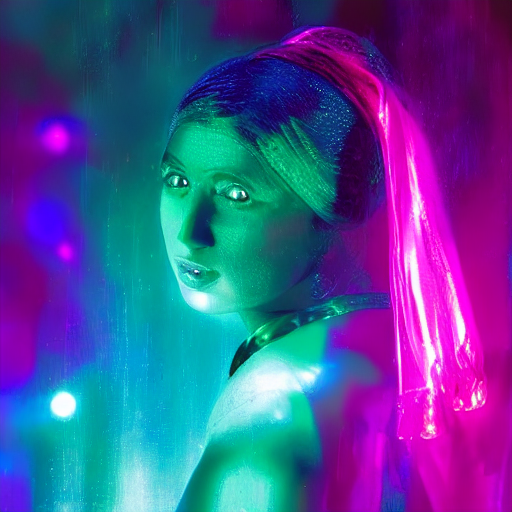

In [8]:
prompt = "disco dancer with colorful lights"
num_steps = 20
seed = 0

out_image = pipe(
    prompt,
    num_inference_steps=num_steps,
    generator=torch.manual_seed(seed),
    image=canny_image
).images[0]

out_image

In [9]:
from transformers import pipeline
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel, UniPCMultistepScheduler
from PIL import Image
import numpy as np
import torch
from diffusers.utils import load_image

depth_estimator = pipeline('depth-estimation')

No model was supplied, defaulted to Intel/dpt-large and revision e93beec (https://huggingface.co/Intel/dpt-large).
Using a pipeline without specifying a model name and revision in production is not recommended.


Some weights of DPTForDepthEstimation were not initialized from the model checkpoint at Intel/dpt-large and are newly initialized: ['neck.fusion_stage.layers.0.residual_layer1.convolution1.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution1.weight', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


In [12]:
controlnet_model = "fusing/stable-diffusion-v1-5-controlnet-depth"
sd_model = "andite/anything-v4.0"

new_controlnet = ControlNetModel.from_pretrained(
    controlnet_model,
    torch_dtype=torch.float16
)

new_pipe = StableDiffusionControlNetPipeline.from_pretrained(
    sd_model,
    controlnet=new_controlnet,
    safety_checker=None,
    torch_dtype=torch.float16,
)

new_pipe.enable_model_cpu_offload()

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_controlnet.StableDiffusionControlNetPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


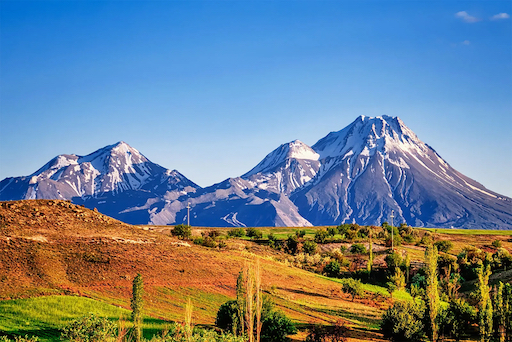

In [14]:
image = load_image("https://i.imgur.com/2V9gTol.jpg")

image

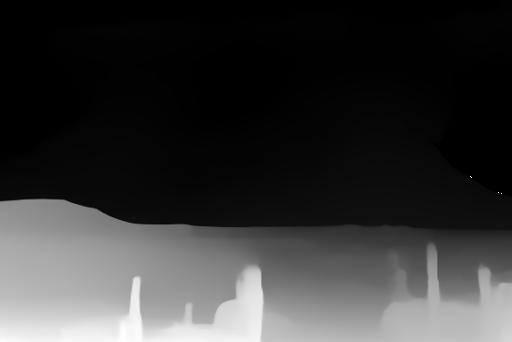

In [15]:
depth_image = depth_estimator(image)['depth']
depth_image = np.array(depth_image)
depth_image = depth_image[:, :, None]
depth_image = np.concatenate([depth_image, depth_image, depth_image], axis=2)
depth_image = Image.fromarray(depth_image)

depth_image

  0%|          | 0/50 [00:00<?, ?it/s]

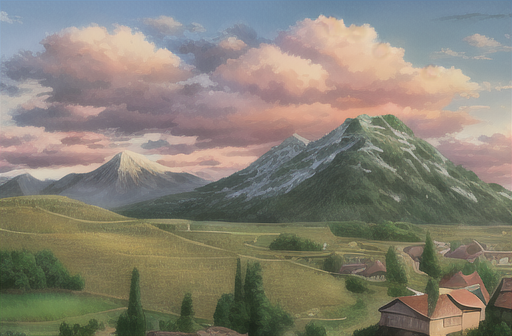

In [16]:
prompt = "scenery, mountain, village, outdoors, sky, clouds"
num_steps = 50
guidance_scale = 14
seed = 1

out_image = new_pipe(
    prompt,
    num_inference_steps=num_steps,
    guidance_scale=guidance_scale,
    generator=torch.manual_seed(seed),
    image=depth_image,
).images[0]

out_image